# GBA 6430 - Big Data Technology in Business
# Dr. Mohammad Salehan
# Graph Mining

This notebook provides an analysis of On-Time Flight Performance and Departure Delays data using GraphFrames for Apache Spark.

Original Source: [Blog](https://databricks.com/blog/2016/03/16/on-time-flight-performance-with-graphframes-for-apache-spark.html) | [Notebook](https://go.databricks.com/hubfs/notebooks/Samples/Miscellaneous/On-Time_Flight_Performance.html)

Source Data: 
* [OpenFlights: Airport, airline and route data](http://openflights.org/data.html)
* [United States Department of Transportation: Bureau of Transportation Statistics (TranStats)](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time)
 * Note, the data used here was extracted from the US DOT:BTS between 1/1/2014 and 3/31/2014*

References:
* [GraphFrames User Guide](http://graphframes.github.io/user-guide.html)
* [GraphFrames: DataFrame-based Graphs (GitHub)](https://github.com/graphframes/graphframes)
* [D3 Airports Example](http://mbostock.github.io/d3/talk/20111116/airports.html)<br><br>
A Graph is a pair G = (V, E), where V is a set whose elements are called vertices (singular: vertex), and E is a set of two-sets (sets with two distinct elements) of vertices, whose elements are called edges (sometimes links or lines).
<img src='https://miro.medium.com/max/703/1*ooL6ZkubiKjDO9-yqOd3jg.jpeg'><br>
Code is adopted from <a href='https://resources.oreilly.com/examples/0636920233145'>O'Reilly Media, Inc.</a>

## Attention: make sure you entered the correct software settings for GraphFrames when creating your cluster.

In [1]:
from graphframes import *
import pyspark.sql.functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pyspark.pandas as ps
ps.set_option('plotting.backend', 'matplotlib')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6,application_1721017390557_0007,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1721017390557_0007/container_1721017390557_0007_01_000001/pyspark.zip/pyspark/pandas/__init__.py:51: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.

## Building the Graph
Now that we've imported our data, we're going to need to build our graph. To do so we're going to do two things. We are going to build the structure of the vertices (or nodes) and we're going to build the structure of the edges. What's awesome about GraphFrames is that this process is incredibly simple. 

In [2]:
# Loading data and transforming
tripdelaysFilePath = "s3://cis4567-salehan/Data/Graphs/896161936_T_ONTIME_REPORTING.csv"
airportsnaFilePath = "s3://cis4567-salehan/Data/Graphs/airports.csv"

nodes = ps.read_csv(airportsnaFilePath, header=None)
cleaned_nodes = nodes[nodes[3] == 'United States'][[1, 4, 6, 7]]\
    .rename(columns = {1 : "name", 4 : "id", 6: "latitude", 7 : "longitude"})
cleaned_nodes = cleaned_nodes[cleaned_nodes["id"] != "\\N"]
relationships = ps.read_csv(tripdelaysFilePath)
cleaned_relationships = relationships[[
    "ORIGIN", "DEST", "FL_DATE", "DEP_DELAY",
    "ARR_DELAY", "DISTANCE", "TAIL_NUM", "OP_CARRIER_FL_NUM",
    "CRS_DEP_TIME", "CRS_ARR_TIME",
    "OP_UNIQUE_CARRIER"]].rename(columns={
    "ORIGIN" : "src", "DEST" : "dst", "DEP_DELAY" : "deptDelay",
    "ARR_DELAY" : "arrDelay", "TAIL_NUM" : "tailNumber",
    "OP_CARRIER_FL_NUM" : "flightNumber", "FL_DATE" : "date",
    "CRS_DEP_TIME" : "time", "CRS_ARR_TIME" : "arrivalTime",
    "DISTANCE" : "distance", "OP_UNIQUE_CARRIER" : "airline"})
cleaned_relationships["deptDelay"] = cleaned_relationships["deptDelay"].astype(float)
cleaned_relationships["arrDelay"] = cleaned_relationships["arrDelay"].astype(float)
cleaned_relationships["time"] = cleaned_relationships["time"].astype(int)
cleaned_relationships["arrivalTime"] = cleaned_relationships["arrivalTime"].astype(int)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1721017390557_0007/container_1721017390557_0007_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.

In [3]:
%%pretty
#  The Vertices (nodes) of our graph are the airports
cleaned_nodes.to_spark().show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name,id,latitude,longitude
Barter Island LRR...,BTI,70.1340026855,-143.582000732
Cape Lisburne LRR...,LUR,68.87509918,-166.1100006
Point Lay LRRS Ai...,PIZ,69.73290253,-163.0050049
Hilo Internationa...,ITO,19.721399307250977,-155.04800415039062
Orlando Executive...,ORL,28.545499801636,-81.332901000977


In [4]:
%%pretty
# The edges of our graph are the flight
cleaned_relationships.to_spark().show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

src,dst,date,deptDelay,arrDelay,distance,tailNumber,flightNumber,time,arrivalTime,airline
CLE,DCA,2018-05-01,-5.0,-18.0,310.0,N14991,4195,1538,1705,EV
ORD,DSM,2018-05-01,-7.0,15.0,299.0,N12540,4196,1005,1128,EV
IAH,LRD,2018-05-01,-11.0,-13.0,301.0,N16178,4197,1005,1126,EV
SHV,IAH,2018-05-01,-5.0,-15.0,192.0,N15980,4197,545,655,EV
AEX,IAH,2018-05-01,-14.0,-37.0,190.0,N15983,4200,545,655,EV


Create a graph object using nodes and vertices.

In [5]:
g = GraphFrame(cleaned_nodes.to_spark(), cleaned_relationships.to_spark())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1721017390557_0007/container_1721017390557_0007_01_000001/pyspark.zip/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.

In [6]:
%%pretty
airlines_reference = ps.read_csv("s3://cis4567-salehan/Data/Graphs/airlines.csv", 
                                 header=None, 
                                 usecols=[1, 3])
airlines_reference = airlines_reference.rename(columns={1 : "name", 3 : "code"})
airlines_reference = airlines_reference[~airlines_reference["code"].isna()]
airlines_reference.to_spark().show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name,code
Unknown,-
Private flight,-
1Time Airline,1T
40-Mile Air,Q5
Ansett Australia,AN


## Simple Queries
Let's start with a set of simple graph queries to understand flight performance and departure delays

#### Determine the number of airports and trips

In [7]:
print("Airports: %d" % g.vertices.count())
print("Trips: %d" % g.edges.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Airports: 1333
Trips: 616529

### Popular airports
Which airports have the most departing flights? We can work out the number of outgoing
flights from an airport using the `Degree Centrality` algorithm:

In [8]:
%%pretty
airports_degree = g.outDegrees.pandas_api().rename(columns={"id" : "oId"})
full_airports_degree = ps.merge(airports_degree, g.vertices.pandas_api(),
                                left_on="oId", right_on="id"
                               ).sort_values("outDegree", ascending=False
                                            )[["id", "name", "outDegree"]]
full_airports_degree.to_spark().show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id,name,outDegree
ATL,Hartsfield Jackso...,33837
ORD,Chicago O'Hare In...,28338
DFW,Dallas Fort Worth...,23765
CLT,Charlotte Douglas...,20251
DEN,Denver Internatio...,19836
LAX,Los Angeles Inter...,19059
PHX,Phoenix Sky Harbo...,15103
SFO,San Francisco Int...,14934
LGA,La Guardia Airport,14709
IAH,George Bush Inter...,14407


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

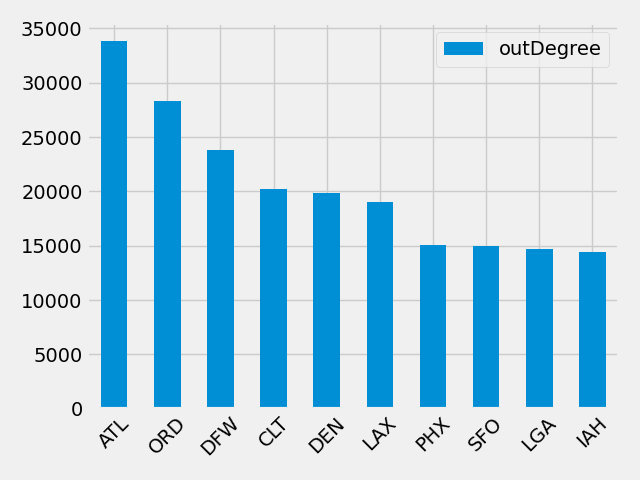

In [9]:
plt.clf()
plt.style.use('fivethirtyeight')
ax=(full_airports_degree
      .iloc[:10]
    .plot(kind='bar', x='id', y='outDegree'))
ax.xaxis.set_label_text("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
%matplot plt

#### Determining the number of delayed vs. on-time / early flights

In [10]:
# Determining number of on-time / early flights vs. delayed flights
edges = g.edges.pandas_api()
print ("On-time / Early Flights: %d" % edges[edges.arrDelay <= 0].shape[0])
print ("Delayed Flights: %d" % edges[edges.arrDelay > 0].shape[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

On-time / Early Flights: 389878
Delayed Flights: 217432

## Delays from ORD
In our scenario, we frequently travel between the west and east coasts and want to see
delays through a midpoint hub like Chicago O’Hare International Airport (ORD).
This dataset contains flight delay data, so we can dive right in.<br>
The following code finds the average delay of flights departing from ORD grouped by
the destination airport.

In [11]:
%%pretty
delayed_flights = edges[
    (edges.src == 'ORD') & (edges.deptDelay > 0)
    ].groupby("dst").agg(averageDelay = ("deptDelay", "mean"), 
                        numberOfDelays = ("deptDelay", "count")).round(2)
ps.merge(delayed_flights, g.vertices.pandas_api(), left_index=True, right_on='id'
        ).sort_values("averageDelay", ascending=False
                     )[["name", "averageDelay", "numberOfDelays"]].to_spark().show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name,averageDelay,numberOfDelays
North Central Wes...,145.08,12
Kahului Airport,119.67,9
Sawyer Internatio...,114.75,12
Mobile Regional A...,102.2,10
Trenton Mercer Ai...,101.18,17
Asheville Regiona...,98.5,28
Long Island Mac A...,94.08,13
Ted Stevens Ancho...,83.74,23
Burlington Intern...,83.2,25
Houghton County M...,79.18,17


This is interesting, but one data point really stands out: 12 flights from ORD to CKB
have been delayed by more than 2 hours on average! Let’s find the flights between
those airports using `BFS` and see what’s going on:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

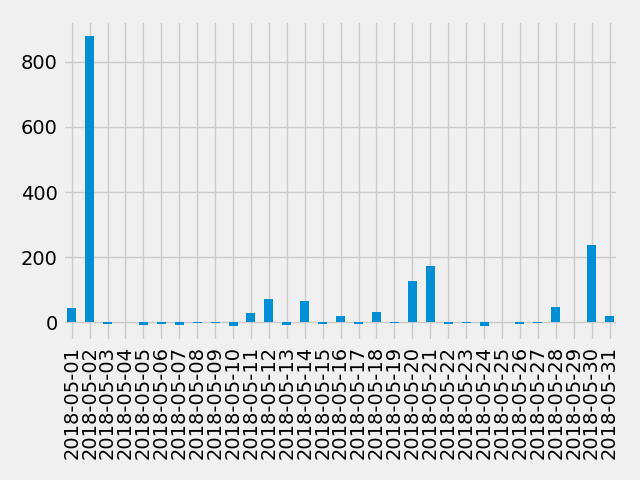

In [12]:
from_expr = 'id = "ORD"'
to_expr = 'id = "CKB"'
ord_to_ckb = g.bfs(from_expr, to_expr)
ord_to_ckb = ord_to_ckb.select(
    F.col("e0.date"),
    F.col("e0.time"),
    F.col("e0.flightNumber"),
    F.col("e0.deptDelay"))

plt.clf()
ax = (ord_to_ckb
    .sort("date")
    .pandas_api()
    .plot(kind='bar', x='date', y='deptDelay', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()
%matplot plt

About half of the flights were delayed, but the delay of more than 14 hours on May 2,
2018, has massively skewed the average. The result shows that this was due to a single outlier day rather than being a systemic problem.

## City / Flight Relationships through Motif Finding
To more easily understand the complex relationship of city airports and their flights with each other, we can use `motifs` to find patterns of airports (i.e. `vertices`) connected by flights (i.e. `edges`). The result is a `DataFrame` in which the column names are given by the `motif` keys.  
The `motif` `(a)-[ab]->(b); (b)-[bc]->(c)` finds flights coming into and out from
the same airport. We then filter the resulting pattern to find flights with:
* A sequence where the first flight arrives at SFO and the second flight departs
from SFO
* Delays of over 30 minutes when arriving at or departing from SFO
* The same flight number and airline

### Bad day at SFO
Let’s consider delays at an airport known for fog-related “low ceiling” issues: San
Francisco International Airport (SFO). Let’s use motifs to find the most-delayed flights going into and out of SFO on
May 11, 2018. The following code will find these delays:

In [13]:
motifs = (g.find("(a)-[ab]->(b); (b)-[bc]->(c)")
    .filter("""(b.id = 'SFO') and
    (ab.date = '2018-05-11' and bc.date = '2018-05-11') and
    (ab.arrDelay > 30 or bc.deptDelay > 30) and
    (ab.flightNumber = bc.flightNumber) and
    (ab.airline = bc.airline) and
    (ab.time < bc.time)"""))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1721017390557_0007/container_1721017390557_0007_01_000001/pyspark.zip/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")

In [14]:
result = (motifs.withColumn("delta", motifs.bc.deptDelay - motifs.ab.arrDelay)
    .select("ab", "bc", "delta")
    .sort("delta", ascending=False))
result.select(
    F.col("ab.src").alias("a1"),
    F.col("ab.time").alias("a1DeptTime"),
    F.col("ab.arrDelay"),
    F.col("ab.dst").alias("a2"),
    F.col("bc.time").alias("a2DeptTime"),
    F.col("bc.deptDelay"),
    F.col("bc.dst").alias("a3"),
    F.col("ab.airline"),
    F.col("ab.flightNumber"),
    F.col("delta")
    ).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----------+--------+---+----------+---------+---+-------+------------+-----+
| a1|a1DeptTime|arrDelay| a2|a2DeptTime|deptDelay| a3|airline|flightNumber|delta|
+---+----------+--------+---+----------+---------+---+-------+------------+-----+
|PDX|      1130|   -18.0|SFO|      1350|    178.0|BUR|     WN|        1454|196.0|
|ACV|      1755|    -9.0|SFO|      2235|     64.0|RDM|     OO|        5700| 73.0|
|BWI|       700|    -3.0|SFO|      1125|     49.0|IAD|     UA|         753| 52.0|
|ATL|       740|    40.0|SFO|      1110|     77.0|SAN|     UA|        1900| 37.0|
|BUR|      1405|    25.0|SFO|      1600|     39.0|PDX|     WN|         157| 14.0|
|DTW|       835|    34.0|SFO|      1135|     44.0|DTW|     DL|         745| 10.0|
|DEN|      1830|    25.0|SFO|      2045|     33.0|BUR|     WN|        1783|  8.0|
|PDX|      1855|   119.0|SFO|      2120|    117.0|DEN|     WN|        5789| -2.0|
|BUR|      2025|    31.0|SFO|      2230|     11.0|PHX|     WN|        1585|-20.0|
+---+----------+

we can see that this cluster is apparently more hub-focused, with some
additional northwestern stops along the way.

## Breadth First Search 
Breadth-first search (BFS) is designed to traverse the graph to quickly find the desired vertices (i.e. airports) and edges (i.e flights).  Let's try to find the shortest number of connections between cities based on the dataset.  Note, these examples do not take into account of time or distance, just hops between cities.
<a href='http://mishadoff.com/blog/dfs-on-binary-tree-array/' >Breadth first vs depth first search</a><br>
<img src='https://www.freelancinggig.com/blog/wp-content/uploads/2019/02/BFS-and-DFS-Algorithms.png' />

In [15]:
%%pretty
# Example 1: Direct Seattle to San Francisco 
filteredPaths = g.bfs(
  fromExpr = "id = 'SEA'",
  toExpr = "id = 'SFO'",
  maxPathLength = 1)
filteredPaths.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

from,e0,to
{Seattle Tacoma I...,"{SEA, SFO, 2018-0...",{San Francisco In...
{Seattle Tacoma I...,"{SEA, SFO, 2018-0...",{San Francisco In...
{Seattle Tacoma I...,"{SEA, SFO, 2018-0...",{San Francisco In...
{Seattle Tacoma I...,"{SEA, SFO, 2018-0...",{San Francisco In...
{Seattle Tacoma I...,"{SEA, SFO, 2018-0...",{San Francisco In...


As you can see, there are a number of direct flights between Seattle and San Francisco.

In [16]:
%%pretty
# Example 2: Direct San Francisco and Buffalo
filteredPaths = g.bfs(
  fromExpr = "id = 'SFO'",
  toExpr = "id = 'BUF'",
  maxPathLength = 1)
filteredPaths.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name,id,latitude,longitude


But there are no direct flights between San Francisco and Buffalo.

In [17]:
%%pretty
# Example 2a: Flying from San Francisco to Buffalo
filteredPaths = g.bfs(
  fromExpr = "id = 'SFO'",
  toExpr = "id = 'BUF'",
  maxPathLength = 2)
filteredPaths.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

from,e0,v1,e1,to
{San Francisco In...,"{SFO, AUS, 2018-0...",{Austin Bergstrom...,"{AUS, BUF, 2018-0...",{Buffalo Niagara ...
{San Francisco In...,"{SFO, AUS, 2018-0...",{Austin Bergstrom...,"{AUS, BUF, 2018-0...",{Buffalo Niagara ...
{San Francisco In...,"{SFO, AUS, 2018-0...",{Austin Bergstrom...,"{AUS, BUF, 2018-0...",{Buffalo Niagara ...
{San Francisco In...,"{SFO, AUS, 2018-0...",{Austin Bergstrom...,"{AUS, BUF, 2018-0...",{Buffalo Niagara ...
{San Francisco In...,"{SFO, AUS, 2018-0...",{Austin Bergstrom...,"{AUS, BUF, 2018-0...",{Buffalo Niagara ...


But there are flights from San Francisco to Buffalo with Boston as the transfer point.

## Determining Airport Ranking using PageRank
There are a large number of flights and connections through these various airports included in this Departure Delay Dataset.  Using the `pageRank` algorithm, Spark iteratively traverses the graph and determines a rough estimate of how important the airport is.<br>
PageRank is a “vote”, by all the other pages on the Web, about how important a page
is. A link to a page counts as a vote of support. If there’s no link, there’s no support (but it’s
an abstention from voting rather than a vote against the page).<br>
<img src='https://upload.wikimedia.org/wikipedia/en/thumb/8/8b/PageRanks-Example.jpg/400px-PageRanks-Example.jpg' />

Some pages have no links out. It is also possible to fall into an unproductive loop. Hence, at each step, the random walk might restart randomly using the reset probability value (epsilon &#949;).

In [18]:
# Determining Airport ranking of importance using pageRank
ranks = g.pageRank(resetProbability=0.15, maxIter=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1721017390557_0007/container_1721017390557_0007_01_000001/pyspark.zip/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  "DataFrame.sql_ctx is an internal property, and will be removed "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

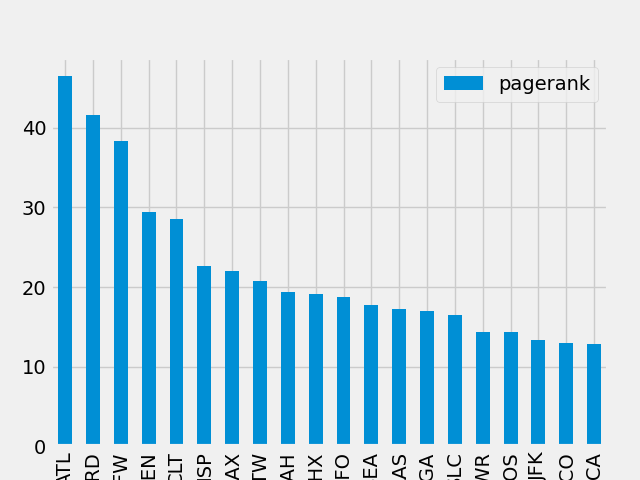

In [19]:
#plot top 20 airports
df = ranks.vertices.pandas_api().sort_values("pagerank", ascending=False).iloc[:20]
df.plot(x='id', y='pagerank', kind='bar')
#plt.show()
%matplot plt

## Interconnected Airports by Airline
If we start from a specific US airport, how many different airports can we visit and come back to the starting airport using the same airline?

In [20]:
airlines = g.edges.pandas_api()
airlines = airlines.groupby("airline").agg(flights=("airline", "count"))
full_name_airlines = ps.merge(airlines_reference, airlines, left_on="code", right_index=True
                             )[["code", "name", "flights"]].sort_values("flights", ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now let’s create a bar chart showing our airlines:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

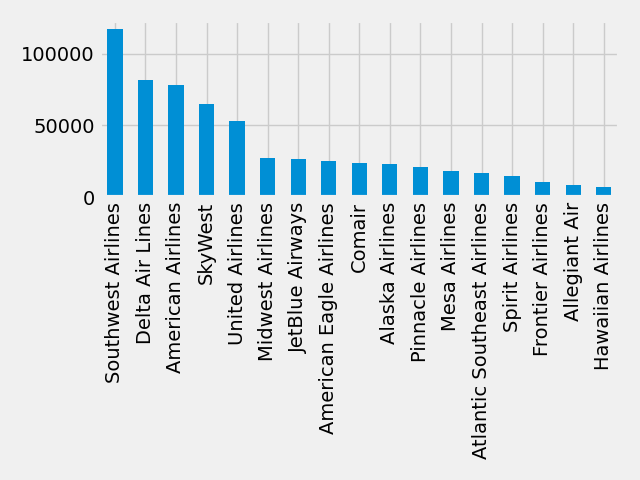

In [21]:
plt.clf()
ax = (full_name_airlines.plot(kind='bar', x='name', y='flights', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()
%matplot plt

We can write the following code to create a DataFrame containing each airline and
the number of airports of its largest `strongly connected component`.

In [22]:
def find_scc_components(g, airline):
    # Create a subgraph containing only flights on the provided airline
    airline_relationships = g.edges[g.edges.airline == airline]
    airline_graph = GraphFrame(g.vertices, airline_relationships)
    # Calculate the Strongly Connected Components
    scc = airline_graph.stronglyConnectedComponents(maxIter=10).pandas_api()
    # Find the size of the biggest component and return that
    return (scc
        .groupby("component")
        .size()
        .sort_values(ascending=False).iloc[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# Calculate the largest strongly connected component for each airline
airline_scc = [(airline, find_scc_components(g, airline))
                for airline in airlines.to_pandas().index.tolist()]
airline_scc_df = ps.DataFrame(airline_scc, columns=['id', 'sccCount'])
# Join the SCC DataFrame with the airlines DataFrame so that we can show
# the number of flights an airline has alongside the number of
# airports reachable in its biggest component
airline_reach = ps.merge(airline_scc_df, full_name_airlines, left_on="id", right_on="code", how='left'
                        )[["code", "name", "flights", "sccCount"]
                         ].sort_values("sccCount", ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1721017390557_0007/container_1721017390557_0007_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/mnt1/yarn/usercache/livy/appcache/application_1721017390557_0007/container_1721017390557_0007_01_000001/pyspark.zip/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  "DataFrame.sql_ctx is an internal property, and will be removed "
/mnt1/yarn/usercache/livy/appcache/application_1721017390557_0007/container_1721017390557_0007_01_000001/pyspark.zip/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directl

Now let’s create a bar chart showing our airlines:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-16:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 72



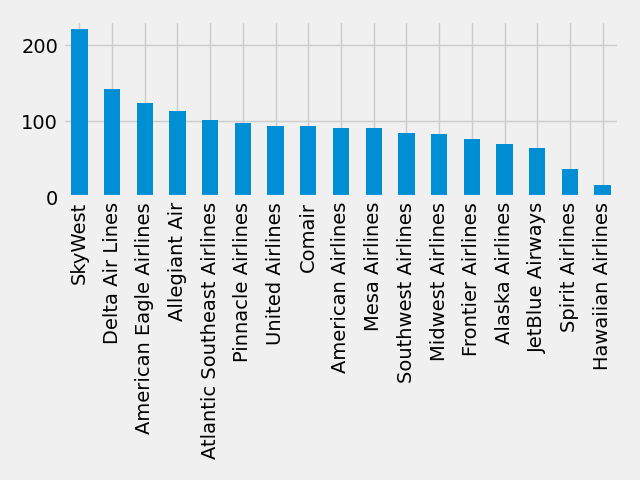

In [24]:
plt.clf()
# airline_reach.plot(kind='bar', x='name', y='sccCount')
# %matplot plt
ax = (airline_reach.to_pandas().plot(kind='bar', x='name', y='sccCount', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()
%matplot plt

SkyWest has the largest community, with over 200 strongly connected airports. This
might partially reflect its business model as an affiliate airline which operates aircraft
used on flights for partner airlines. Southwest, on the other hand, has the highest
number of flights but only connects around 80 airports.  
Now let’s write a function that uses the `Strongly Connected Components` algorithm to
find airport groupings for each airline where all the airports have flights to and from
all the other airports in that group:

Now let’s say most of the frequent flyer points we have are with Delta Airlines (DL).
Can we find airports that form communities within the network for that particular
airline carrier?

In [25]:
airline_relationships = g.edges.filter("airline = 'DL'")
airline_graph = GraphFrame(g.vertices, airline_relationships)
clusters = airline_graph.labelPropagation(maxIter=10)
(clusters
    .sort("label")
    .groupby("label")
    .agg(F.collect_list("id").alias("airports"),
    F.count("id").alias("count"))
    .sort("count", ascending=False)
    .show(truncate=70, n=10))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-17:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 96



+-------------+----------------------------------------------------------------------+-----+
|        label|                                                              airports|count|
+-------------+----------------------------------------------------------------------+-----+
|1606317768706|[OMA, ICT, GNV, MEM, CLE, LFT, EWR, DAL, MYR, MDT, IAH, ELP, CAE, P...|   89|
|1219770712067|[BOS, OAK, OGG, MCI, MSN, PHX, GEG, SFO, LAX, CVG, JNU, BOI, KOA, D...|   53|
|            0|                                                                 [BGM]|    1|
|            1|                                                                 [CNU]|    1|
|            2|                                                                 [DAW]|    1|
|            3|                                                                 [FMY]|    1|
|            4|                                                                 [LEB]|    1|
|            5|                                                       

Most of the airports DL uses have clustered into two groups; let’s drill down into
those. There are too many airports to show here, so we’ll just show the airports with
the biggest degree (ingoing and outgoing flights). We can write the following code to
calculate airport degree:

In [26]:
%%pretty
all_flights = g.degrees.pandas_api().rename(columns={"id": "aId"})
clusters_ps = clusters.pandas_api()
(ps.merge(clusters_ps[clusters_ps.label=="1606317768706"], all_flights, left_on="id", right_on="aId")
    .sort_values("degree", ascending=False)
    [["id", "name", "degree"]]
    .to_spark().show(20))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id,name,degree
DFW,Dallas Fort Worth...,47514
CLT,Charlotte Douglas...,40495
IAH,George Bush Inter...,28814
EWR,Newark Liberty In...,25131
PHL,Philadelphia Inte...,20804
BWI,Baltimore/Washing...,18989
MDW,Chicago Midway In...,15178
BNA,Nashville Interna...,12455
DAL,Dallas Love Field,12084
IAD,Washington Dulles...,11566


we can see that this cluster is actually focused on the East Coast to the
Midwest of the United States.

And now let’s do the same thing with the second-largest cluster:

In [27]:
%%pretty
(ps.merge(clusters_ps[clusters_ps.label=="1219770712067"], all_flights, left_on="id", right_on="aId")
    .sort_values("degree", ascending=False)
    [["id", "name", "degree"]]
    .to_spark().show(20))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id,name,degree
ATL,Hartsfield Jackso...,67672
ORD,Chicago O'Hare In...,56681
DEN,Denver Internatio...,39671
LAX,Los Angeles Inter...,38116
PHX,Phoenix Sky Harbo...,30206
SFO,San Francisco Int...,29865
LGA,La Guardia Airport,29416
LAS,McCarran Internat...,27801
DTW,Detroit Metropoli...,27477
MSP,Minneapolis-St Pa...,27163
